# Quality Control prediction for incoming goods.
    
### **Grzegorz Kowalczyk**
#### 01/03/2024

* **1 Introduction**
* **2 Load and check data**
    * 2.1 Load data
    * 2.2 Data dictionary
    * 2.3 Data types, empty strings
    * 2.4 Outlier detection
    * 2.5 Check for null and missing values
* **4 Data preprocessing**
    * 4.1 Data cleaning
* **3 Feature analysis**
    * 3.1 Numerical values
    * 3.2 Categorical values
* **4 Filling missing Values**
    * 4.1 Age
* **5 Feature engineering**
    * 5.1 Name/Title
    * 5.2 Family Size
    * 5.3 Cabin
    * 5.4 Ticket
 
* **6 Scaling**
  
* **7 Modeling**
    * 6.1 Simple modeling
        * 6.1.1 Cross validate models
        * 6.1.2 Hyperparamater tunning for best models
        * 6.1.3 Plot learning curves
        * 6.1.4 Feature importance of the tree based classifiers
    * 6.2 Ensemble modeling
        * 6.2.1 Combining models
    * 6.3 Prediction
        * 6.3.1 Predict and Submit results

## 1. Introduction

In the context of mid-sized manufacturing enterprises, factories often engage in the production of a multitude of products, necessitating the procurement of numerous parts and components from a diverse array of international suppliers, often employing dual sourcing strategies.

This project endeavors to develop a predictive model, leveraging real-world production data, specifically focusing on aluminum LED profiles manufacturing, with the objective of accurately classifying incoming goods as either 'OK' or 'NOK' (not OK).

A robust working model, enhanced with additional refinements, holds the potential to provide valuable insights not only to quality assurance personnel but also to logistics professionals, aiding in supplier selection processes. Moreover, it can serve as a tool for research and development teams, facilitating the identification of product features during the design phase that mitigate the likelihood of faulty deliveries.


In [328]:
import pandas as pd
import numpy as np
import missingno
import seaborn as sns
import warnings
from collections import Counter
warnings.filterwarnings("ignore")
# !pip install openpyxl

## 2. Load and check data

### 2.1 load data

In [329]:
df = pd.read_excel('../Github depo/QC_encoded_data.xlsx')

In [330]:
df.head()

date finish delivered_pcs_pack pack_weight_kg OK_NOK  pcs_lenght_mm  \
0  13,01,2017    C-0                NaN            NaN    NOK            NaN   
1  13,01,2017    C-0                NaN            NaN    NOK            NaN   
2  13,01,2017    C-0                NaN            NaN    NOK            NaN   
3  13,01,2017    C-0                NaN            NaN    NOK            NaN   
4  19,01,2017    C-0                NaN            NaN    NOK            NaN   

  quantity_pcs  overal_weight_kg  pcs_pck   name_e drawing_no_e shape_no_e  \
0          NaN               NaN     40.0    Regor          DR0        SH0   
1          NaN               NaN     40.0  Procyon          DR1        SH1   
2          NaN               NaN     40.0    Regor          DR0        SH0   
3          NaN               NaN     40.0    Regor          DR0        SH0   
4          NaN               NaN     40.0     Grus          DR2        SH2   

  supplier_e  
0        SU0  
1        SU0  
2        SU0  
3        SU0  
4        SU1

In [331]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                6403 non-null   object 
 1   finish              6448 non-null   object 
 2   delivered_pcs_pack  4807 non-null   object 
 3   pack_weight_kg      2411 non-null   object 
 4   OK_NOK              6448 non-null   object 
 5   pcs_lenght_mm       4514 non-null   float64
 6   quantity_pcs        4514 non-null   object 
 7   overal_weight_kg    4488 non-null   float64
 8   pcs_pck             6350 non-null   float64
 9   name_e              6448 non-null   object 
 10  drawing_no_e        6448 non-null   object 
 11  shape_no_e          6448 non-null   object 
 12  supplier_e          6448 non-null   object 
dtypes: float64(3), object(10)
memory usage: 3.4 MB


Reorder the columns

In [332]:
new_order = ['OK_NOK','date', 'name_e', 'shape_no_e', 'drawing_no_e', 'finish', 'supplier_e', 'pcs_pck','delivered_pcs_pack', 'pack_weight_kg', 
       'pcs_lenght_mm', 'quantity_pcs', 'overal_weight_kg']

In [333]:
df = df[new_order]

In [334]:
df.shape

(6448, 13)

In [335]:
df.describe()

pcs_pck  pcs_lenght_mm  overal_weight_kg
count  6350.000000    4514.000000       4488.000000
mean     38.541890    4078.381701        438.282907
std      22.971019     226.998957        226.470685
min       2.000000    1500.000000          0.000000
25%      20.000000    4050.000000        258.390000
50%      40.000000    4150.000000        450.357925
75%      40.000000    4150.000000        568.218000
max     100.000000    5100.000000       1702.413000

Describe function shows only 3 columns which means only those 3 are numeric, I will address this issue later on.

## 2.2 Data dictionary

* 0.   **OK_NOK**:
      This column contains a target label   
* 1.   **date**:
      Date of delivery
* 2.   **name_e**:
      This column consist of aluminum profile names
* 3.   **shape_no_e**:
      Number that defines shape of the aluminium profile.
      Shape itself dosn't describe the final product because many suppliers can deliver the same shape in many colours and at different lenghts
* 4.   **drawing_no_e**:
      Describes a shape and supplier but dosn't contain information about colours and different lenghts
* 5.   **finish**:
      Information about the colour of the profile
* 6.   **supplier_e**:
      Name of the supplier
* 7.   **pcs_pck**:
      Number of aluminium profiles that should be delivered in one package
* 8.   **delivered_pcs_pack**:
      Number of aluminium profiles that ware delivered in one package
* 9.   **pack_weight_kg**:
      Weight of one package
* 10.  **pcs_lenght_mm**:
      Lenght of the aluminium profiles
* 11.  **quantity_pcs**:
      How many pcs where delivered 
* 12.  **overal_weight_kg**:
      The overal weight delivered profiles

## 2.3 Data types, empty strings

### Since our target is binary classification we can map OK = 1 and NOK = 0

In [336]:
df['OK_NOK'] = df['OK_NOK'].map({'OK': 1, 'NOK': 0})

In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name_e              6448 non-null   object 
 3   shape_no_e          6448 non-null   object 
 4   drawing_no_e        6448 non-null   object 
 5   finish              6448 non-null   object 
 6   supplier_e          6448 non-null   object 
 7   pcs_pck             6350 non-null   float64
 8   delivered_pcs_pack  4807 non-null   object 
 9   pack_weight_kg      2411 non-null   object 
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4514 non-null   object 
 12  overal_weight_kg    4488 non-null   float64
dtypes: float64(3), int64(1), object(9)
memory usage: 655.0+ KB


 The columns:
* 'delivered_pcs_pack',
* 'pack_weight_kg',
* 'quantity_pcs'
  
   are mix of strings, numeric and nans that I need to handle first.

* **delivered_pcs_pack'**

In [338]:
delivered_pcs_vc = df['delivered_pcs_pack'].value_counts(dropna=False)


In [339]:
# Change the type of whole column to str

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].astype(str)

# Filter out rows containing '40 / 60'
filtered_df = df[df['delivered_pcs_pack'].str.contains('40 / 60')]


In [340]:
#  Replace values, strip white spaces:

df['delivered_pcs_pack'] = df['delivered_pcs_pack'].replace(['20 SZT', 'BRAK', '-', '0', '40 / 60'], ['20', 'np.nan', 'np.nan', 'np.nan', '40']).str.strip()

# Change the whole column back to numeric

df['delivered_pcs_pack'] = pd.to_numeric(df['delivered_pcs_pack'], errors='coerce')


* **pack_weight_kg**

In [341]:
# Check for strings, nan etc, then convert to nummeric.
pack_weight_kg_vc = df['pack_weight_kg'].value_counts(dropna=False)
filtered_pack_weight_kg_vc = pack_weight_kg_vc[pack_weight_kg_vc<2]


In [342]:
df['pack_weight_kg'] =  pd.to_numeric(df['pack_weight_kg'], errors='coerce')
df['pack_weight_kg'] = df['pack_weight_kg'].round(decimals=1)
df['pack_weight_kg'].value_counts(dropna=False).index

Index([  nan,  27.0,  32.2,  21.4,  22.7,  31.3,  25.4,  19.4,  27.1,  32.0,
       ...
        40.6,  40.7,  34.4,  43.5,  55.0,  39.5,  48.5, 350.0,  18.5,  12.2],
      dtype='float64', name='pack_weight_kg', length=259)

* **quantity_pcs**

In [343]:
quantity_pcs_vc = df['quantity_pcs'].value_counts(dropna=False)
quantity_pcs_vc

quantity_pcs
NaN       1934
600        115
360         94
400         86
1200        77
300         77
480         68
800         65
1000        65
240         65
900         63
120         63
288         53
1400        50
1800        48
180         45
128         42
500         41
200         40
840         39
160         38
1050        38
750         37
2000        36
450         36
420         34
960         32
550         30
280         30
140         28
1600        28
270         28
150         27
640         26
950         26
720         25
1250        25
144         23
100         22
216         22
80          22
1500        21
520         21
540         21
1100        21
60          20
320         20
440         19
700         19
1350        19
650         19
1280        18
250         18
1150        17
1900        16
560         16
350         16
390         15
1040        15
96          15
1120        15
380         14
680         14
630         14
1300        14
1080        

In [344]:
df['quantity_pcs'] = pd.to_numeric(df['quantity_pcs'], errors='coerce')

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name_e              6448 non-null   object 
 3   shape_no_e          6448 non-null   object 
 4   drawing_no_e        6448 non-null   object 
 5   finish              6448 non-null   object 
 6   supplier_e          6448 non-null   object 
 7   pcs_pck             6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overal_weight_kg    4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 655.0+ KB


## 2.4 Outlier detection

In [346]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from "pcs_pck", "pcs_lenght_mm", "overal_weight_kg", "quantity_pcs","pack_weight_kg","delivered_pcs_pack"
Outliers_to_drop = detect_outliers(df,2,["pcs_pck", "pcs_lenght_mm", "overal_weight_kg", "quantity_pcs","pack_weight_kg","delivered_pcs_pack"])

In [347]:
Outliers_to_drop

[]

Comment: It appears that there are no outliers in our data.

In [348]:
df.describe()

OK_NOK      pcs_pck  delivered_pcs_pack  pack_weight_kg  \
count  6448.000000  6350.000000         4801.000000     2405.000000   
mean      0.810174    38.541890           38.570142       27.548732   
std       0.392194    22.971019           22.791827       10.219792   
min       0.000000     2.000000            0.250000        0.000000   
25%       1.000000    20.000000           20.000000       22.100000   
50%       1.000000    40.000000           40.000000       27.000000   
75%       1.000000    40.000000           40.000000       32.200000   
max       1.000000   100.000000          250.000000      350.000000   

       pcs_lenght_mm  quantity_pcs  overal_weight_kg  
count    4514.000000   4513.000000       4488.000000  
mean     4078.381701    705.673942        438.282907  
std       226.998957    591.612370        226.470685  
min      1500.000000      0.000000          0.000000  
25%      4050.000000    260.000000        258.390000  
50%      4150.000000    525.000000        450.357925  
75%      4150.000000   1000.000000        568.218000  
max      5100.000000   5200.000000       1702.413000

### 2.5 Check for null and missing values

In [349]:
df.isnull().sum().sort_values(ascending=False)

pack_weight_kg        4043
overal_weight_kg      1960
quantity_pcs          1935
pcs_lenght_mm         1934
delivered_pcs_pack    1647
pcs_pck                 98
date                    45
OK_NOK                   0
name_e                   0
shape_no_e               0
drawing_no_e             0
finish                   0
supplier_e               0
dtype: int64

<Axes: >

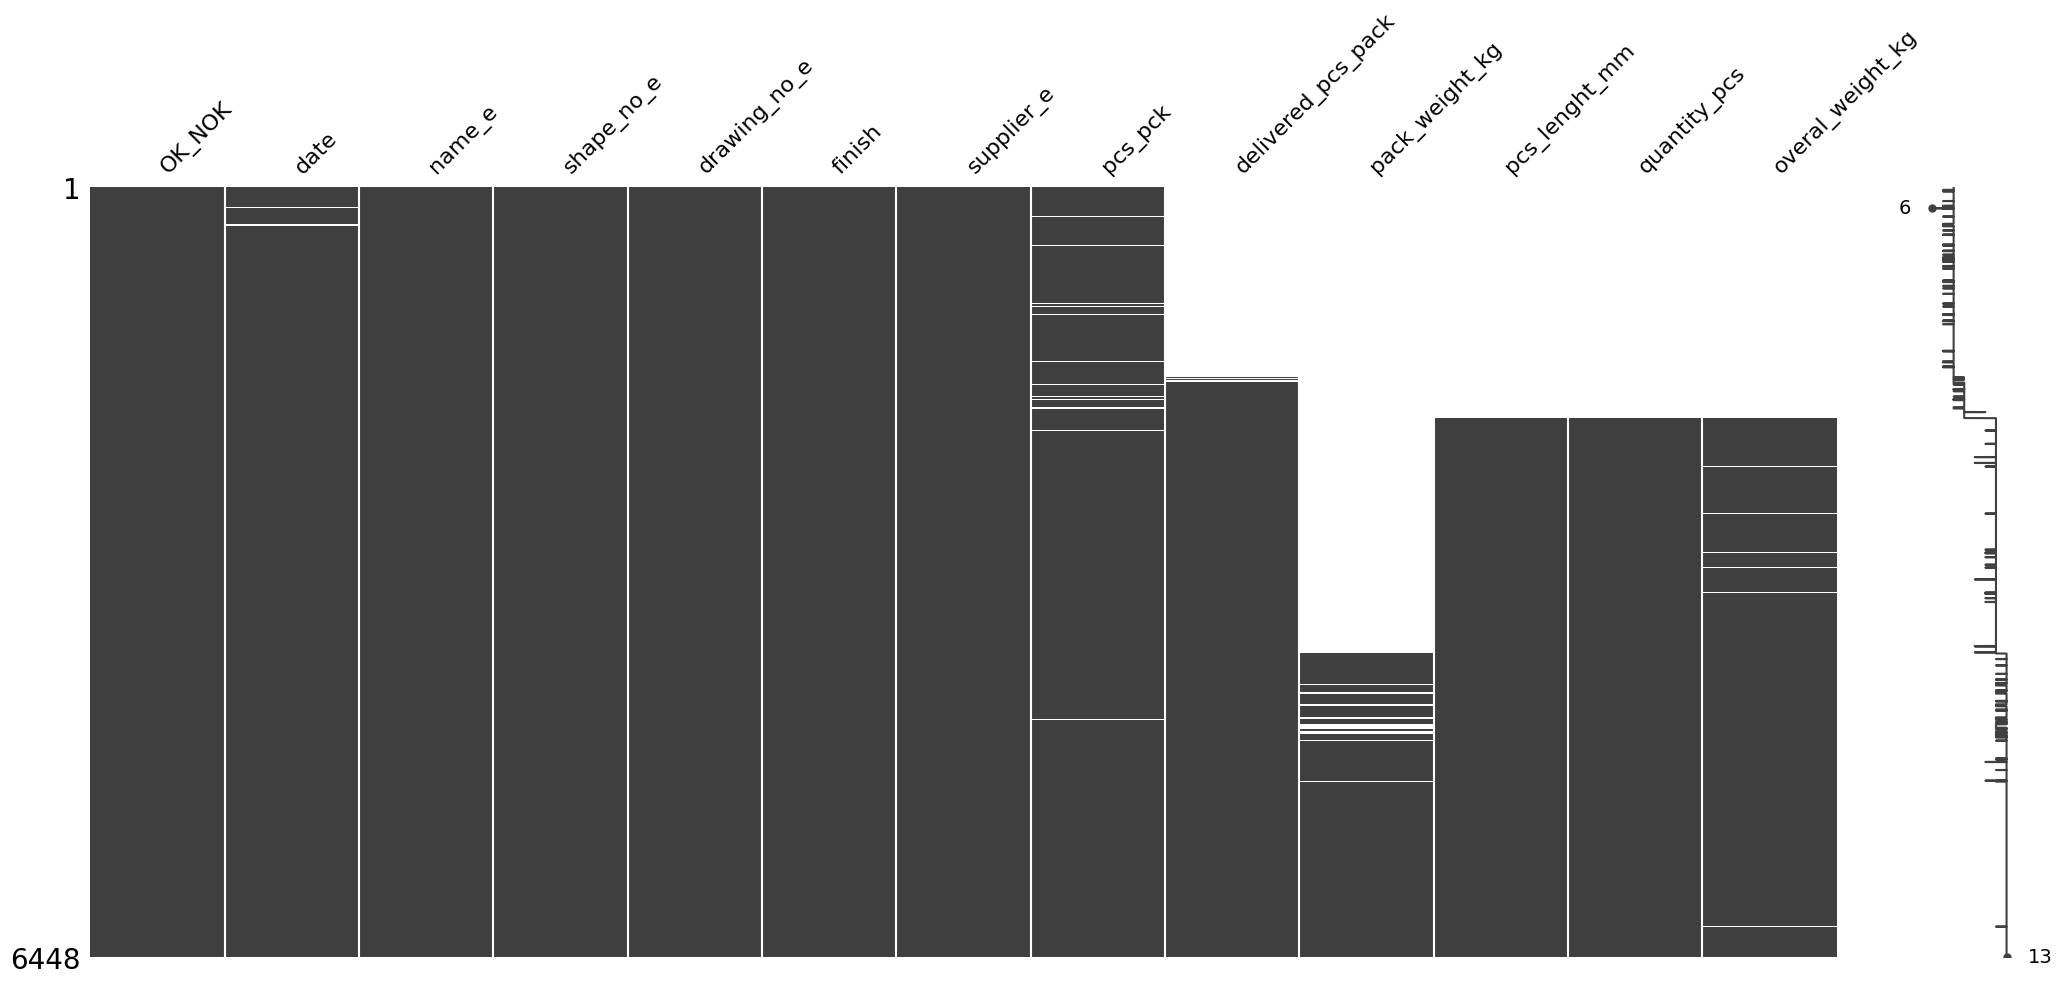

In [350]:
missingno.matrix(df)

<Axes: >

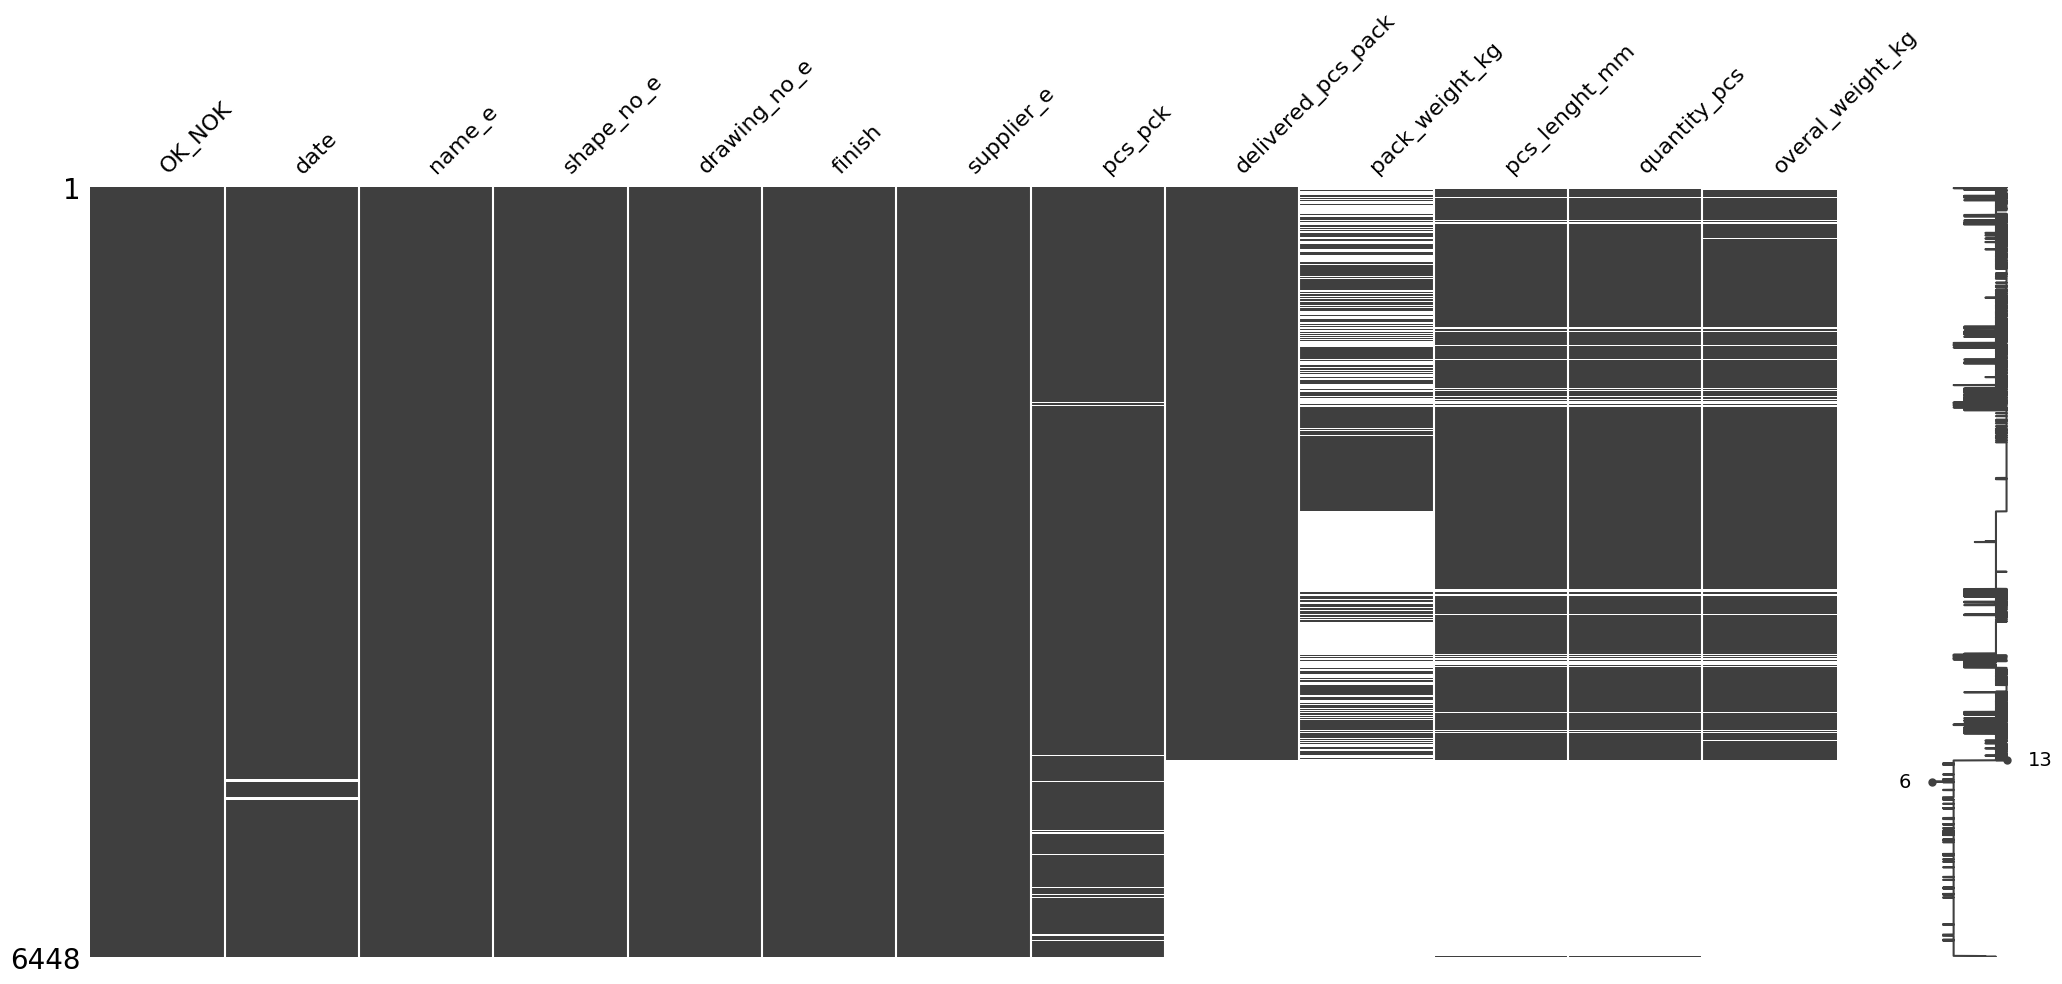

In [351]:
sorted_delivered_pcs_pack = df.sort_values('delivered_pcs_pack')
missingno.matrix(sorted_delivered_pcs_pack)

### 4. Data preprocesing

### 4.1 Data cleaning

In [352]:
df

OK_NOK                 date          name_e shape_no_e drawing_no_e  \
0          0           13,01,2017           Regor        SH0          DR0   
1          0           13,01,2017         Procyon        SH1          DR1   
2          0           13,01,2017           Regor        SH0          DR0   
3          0           13,01,2017           Regor        SH0          DR0   
4          0           19,01,2017            Grus        SH2          DR2   
5          0           19,01,2017           Orion        SH3          DR3   
6          0           19,01,2017     Telescopium        SH4          DR4   
7          1           19,01,2017         Lalande        SH5          DR5   
8          1           19,01,2017         Lalande        SH5          DR5   
9          0           19,01,2017     Telescopium        SH4          DR4   
10         0           19,01,2017        Zavijava        SH6          DR6   
11         0           19,01,2017      Andromeda2        SH7          DR7   
12         1           19,01,2017      Andromeda2        SH7          DR7   
13         1           19,01,2017      Andromeda2        SH7          DR7   
14         0           20,01,2017         Canopus        SH8          DR8   
15         0           24,01,2017         Gemini2        SH9          DR9   
16         0           24,01,2017         Gemini2        SH9          DR9   
17         0           27.01.2017            Grus        SH2          DR2   
18         1           27.01.2017            Grus        SH2          DR2   
19         0           19.12.2017          Phecda        SH5         DR10   
20         0           31.01.2017          Phecda        SH5          DR5   
21         0           31.01.2017          Phecda        SH5          DR5   
22         0           31.01.2017          Phecda        SH5          DR5   
23         0           02.02.2017           Saiph       SH10         DR11   
24         0                  NaN        Equuleus       SH11         DR12   
25         0           18.11.2016          Virgo1        SH9          DR9   
26         0           10.02.2017          Phecda        SH5          DR5   
27         0           10.02.2017          Phecda        SH5          DR5   
28         0           10.02.2017          Phecda        SH5          DR5   
29         0           10.02.2017         Lalande        SH5          DR5   
30         1           10.02.2017         Lalande        SH5          DR5   
31         0           10.02.2017          Orion2       SH12         DR13   
32         0           10.02.2017          Orion2       SH12         DR13   
33         1           14.02.2017          Phecda        SH5          DR5   
34         0           14.02.2017           Regor        SH0          DR0   
35         0           14.02.2017           Regor        SH0          DR0   
36         0                  NaN       Scorpius2       SH13         DR14   
37         0           15.02.2017            Pavo       SH14         DR15   
38         1           15.02.2017            Pavo       SH14         DR15   
39         0           15.02.2017        Centauri       SH15         DR16   
40         1           15.02.2017        Centauri       SH15         DR16   
41         1           15.02.2017        Arcturus       SH15         DR16   
42         1           15.02.2017        Arcturus       SH15         DR16   
43         0           15.02.2017            Pavo       SH14         DR15   
44         1           15.02.2017            Pavo       SH14         DR15   
45         1           15.02.2017     Telescopium        SH4          DR4   
46         0           15.02.2017           Zosma       SH16         DR17   
47         1           15.02.2017     Telescopium        SH4          DR4   
48         0           03.11.2016         Alnitak       SH17         DR18   
49         0           05.01.2017           Vega1       SH18         DR19   
50         0           16.02.2017         Procyon        SH1         DR20   
51

In [353]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   OK_NOK              6448 non-null   int64  
 1   date                6403 non-null   object 
 2   name_e              6448 non-null   object 
 3   shape_no_e          6448 non-null   object 
 4   drawing_no_e        6448 non-null   object 
 5   finish              6448 non-null   object 
 6   supplier_e          6448 non-null   object 
 7   pcs_pck             6350 non-null   float64
 8   delivered_pcs_pack  4801 non-null   float64
 9   pack_weight_kg      2405 non-null   float64
 10  pcs_lenght_mm       4514 non-null   float64
 11  quantity_pcs        4513 non-null   float64
 12  overal_weight_kg    4488 non-null   float64
dtypes: float64(6), int64(1), object(6)
memory usage: 2.6 MB


In [354]:
df.date.iloc[-1]

datetime.datetime(2022, 9, 13, 0, 0)

In [355]:
df.date.isnull().sum()

45

In [356]:
df['is_str'] = df.date.apply(lambda x: True if isinstance(x, str) else False)

In [357]:
df['is_str'].value_counts()

is_str
False    4666
True     1782
Name: count, dtype: int64

In [358]:
df.insert(2, 'is_str', df.pop('is_str'))

In [359]:
is_str_true = df.loc[df['is_str'] == True, 'date']

In [360]:
is_str_true = is_str_true.str.replace(',','.').str.strip()

In [361]:
is_str_true = pd.to_datetime(is_str_true, format='%d.%m.%Y', errors='coerce' )

In [362]:
is_str_true.isnull().sum()

61

In [363]:
is_str_true_idx = is_str_true[is_str_true.isnull()].index

In [374]:
pd.set_option('display.max_rows', None)
df.loc[is_str_true_idx].head(71)

OK_NOK       date  is_str          name_e shape_no_e drawing_no_e  \
72         0 2016-10-12    True     Capricornus       SH22         DR24   
74         0 2016-10-10    True          Nebula        SH0          DR0   
82         0        NaT    True          Phecda        SH5          DR5   
90         1        NaT    True         Electra       SH28         DR30   
91         1        NaT    True        Astraeus        SH6         DR31   
92         1        NaT    True    Microscopium       SH29         DR32   
93         0        NaT    True          Turais       SH22         DR24   
94         0        NaT    True          Turais       SH22         DR24   
95         1        NaT    True            Leo2       SH12         DR13   
96         1        NaT    True            Leo2       SH12         DR13   
97         1        NaT    True         Galaxia        SH2          DR2   
98         1        NaT    True          Pulsar        SH1         DR20   
99         1        NaT    True       Andromeda        SH5          DR5   
102        0        NaT    True        Solstice       SH30         DR33   
103        1        NaT    True         Sputnik       SH30         DR33   
104        0        NaT    True           Hydra       SH31         DR34   
105        1        NaT    True       Sadalsuud       SH19         DR21   
108        1        NaT    True         Alnitak       SH17         DR18   
109        1        NaT    True           Spica       SH32         DR35   
111        0        NaT    True         Apollo1       SH33         DR36   
112        1        NaT    True          Virgo2       SH34         DR37   
113        1        NaT    True       Scorpius1       SH20         DR22   
114        1        NaT    True           Draco       SH35         DR38   
115        1        NaT    True           Draco       SH35         DR38   
116        1        NaT    True          Nebula        SH0         DR39   
117        0        NaT    True       Aquarius1       SH36         DR40   
118        1        NaT    True           Hadar       SH28         DR30   
119        1        NaT    True           Hadar       SH28         DR30   
120        1        NaT    True       Reticulum       SH37         DR41   
121        1        NaT    True  Camelopardalis       SH38         DR42   
122        1        NaT    True          Murzim       SH39         DR43   
123        0        NaT    True         Sputnik       SH30         DR33   
124        1        NaT    True         Sputnik       SH30         DR33   
125        1        NaT    True         Pisces2       SH40         DR44   
126        1        NaT    True         Pisces2       SH40         DR44   
127        1        NaT    True           Gemma       SH41         DR45   
128        1        NaT    True         Phoenix       SH33         DR36   
129        0        NaT    True           Syrma       SH37         DR41   
130        0        NaT    True       Scorpius2       SH13         DR14   
132        1        NaT    True     Capricornus       SH22         DR24   
133        1        NaT    True           Hadar       SH28         DR30   
134        1        NaT    True        Zavijava        SH6         DR31   
135        0        NaT    True            Ursa       SH30         DR33   
136        1        NaT    True       Scorpius2       SH13         DR14   
151        0        NaT    True           Regor        SH0          DR0   
154        1        NaT    True          Phecda        SH5          DR5   
155        1        NaT    True           Regor        SH0          DR0   
233        1 2016-10-12    True           Canis       SH17         DR18   
246        1        NaT    True         Polaris        SH6         DR52   
247        0        NaT    True         Galileo        SH9         DR53   
248        0        NaT    True         Polaris        SH6         DR52   
297        0        NaT    True          Nebula        SH0          DR0   
325        1        NaT    True

In [365]:
df.loc[is_str_true_idx, 'date'] = df.loc[is_str_true_idx, 'date'].str.replace('/','.')

In [366]:
df.loc[72, 'date'] = '12.10.2016'
df.loc[74, 'date'] = '10.10.2016'
df.loc[233, 'date'] = '12.10.2016'
df.loc[426, 'date'] = '28.03.2016'
df.loc[894, 'date'] = '21.02.2018'
df.loc[1532, 'date'] = '12.09.2018'

In [370]:
list_convert_to_time_indx = [72, 74, 233, 426, 894, 1532, 427, 429, 433]

In [371]:
filtered_convert_to_time_indx = df.loc[list_convert_to_time_indx, 'date']

In [372]:
df.date = pd.to_datetime(filtered_convert_to_time_indx, format='%d.%m.%Y', errors='coerce' )

In [373]:
df.loc[72, 'date']

Timestamp('2016-10-12 00:00:00')

In [293]:
import random
from datetime import datetime, timedelta

def random_date(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    random_days = random.randint(0, (end_date - start_date).days)
    return start_date + timedelta(days=random_days)

    

str

In [284]:
is_str_still_true = pd.to_datetime(is_str_true_idx, format='%d.%m.%Y', errors='coerce' )

In [285]:
is_str_still_true.isnull().sum()

61

In [150]:
is_str_true_idx2 = is_str_true2[is_str_true2.isnull()].index

In [142]:
df.loc[df['is_str'] == True, 'date_fmt'] = is_str_true

In [143]:
df.insert(2, 'date_fmt', df.pop('date_fmt'))

In [144]:
df['date_fmt'] = df['date_fmt'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [145]:
df.loc[df['is_str']==True, 'date'] = df['date_fmt']

In [146]:
import random
from datetime import datetime, timedelta

def random_date(year):
    start_date = datetime(year, 1, 1)
    end_date = datetime(year, 12, 31)
    random_days = random.randint(0, (end_date - start_date).days)
    return start_date + timedelta(days=random_days)

In [147]:
df.loc[is_str_true_idx, 'date'] = random_date(2016)

In [148]:
df.loc[is_str_true_idx, 'date']

72      2016-10-15 00:00:00
74      2016-10-15 00:00:00
82      2016-10-15 00:00:00
90      2016-10-15 00:00:00
91      2016-10-15 00:00:00
92      2016-10-15 00:00:00
93      2016-10-15 00:00:00
94      2016-10-15 00:00:00
95      2016-10-15 00:00:00
96      2016-10-15 00:00:00
97      2016-10-15 00:00:00
98      2016-10-15 00:00:00
99      2016-10-15 00:00:00
102     2016-10-15 00:00:00
103     2016-10-15 00:00:00
104     2016-10-15 00:00:00
105     2016-10-15 00:00:00
108     2016-10-15 00:00:00
109     2016-10-15 00:00:00
111     2016-10-15 00:00:00
112     2016-10-15 00:00:00
113     2016-10-15 00:00:00
114     2016-10-15 00:00:00
115     2016-10-15 00:00:00
116     2016-10-15 00:00:00
117     2016-10-15 00:00:00
118     2016-10-15 00:00:00
119     2016-10-15 00:00:00
120     2016-10-15 00:00:00
121     2016-10-15 00:00:00
122     2016-10-15 00:00:00
123     2016-10-15 00:00:00
124     2016-10-15 00:00:00
125     2016-10-15 00:00:00
126     2016-10-15 00:00:00
127     2016-10-15 0

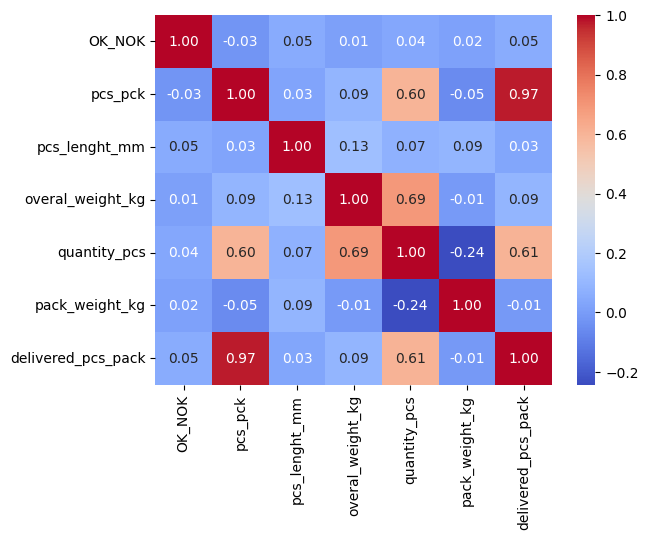

In [149]:
g = sns.heatmap(df[["OK_NOK","pcs_pck", "pcs_lenght_mm", "overal_weight_kg", "quantity_pcs","pack_weight_kg","delivered_pcs_pack"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")